In [1]:
import numpy as np
import json
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input,
    LSTM,
    Dense,
    Embedding,
    Bidirectional,
    Concatenate,
    Dropout,
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu


2025-05-14 22:59:30.964921: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 22:59:30.965513: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 22:59:30.969003: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 22:59:30.976754: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747238370.990701  467162 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747238370.99

In [2]:

# Load data
with open("data_converted.json", "r") as f:
    data = json.load(f)


# Preprocessing function
def preprocess_text(text):
    """Melakukan preprocessing teks dasar"""
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text


# Persiapkan data untuk model prediksi pertanyaan
def prepare_question_prediction_data(data):
    """Siapkan data untuk model prediksi pertanyaan"""
    contexts = []
    tokens_list = []
    ner_list = []
    srl_list = []
    questions = []
    q_types = []

    for item in data:
        for qa in item["qas"]:
            contexts.append(preprocess_text(item["context"]))
            tokens_list.append(item["tokens"])
            ner_list.append(item["ner"])
            srl_list.append(item["srl"])
            questions.append(preprocess_text(qa["question"]))
            q_types.append(qa["type"])
            # Tidak mengambil jawaban (answer) sebagai input

    return contexts, tokens_list, ner_list, srl_list, questions, q_types


# Siapkan data
contexts, tokens_list, ner_list, srl_list, questions, q_types = (
    prepare_question_prediction_data(data)
)

In [3]:

# Tokenizer untuk teks (context, question)
max_vocab_size = 10000
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
all_texts = contexts + questions + [" ".join(item) for item in tokens_list]
tokenizer.fit_on_texts(all_texts)
vocab_size = len(tokenizer.word_index) + 1

# Encoding untuk NER
ner_tokenizer = Tokenizer(oov_token="<OOV>")
ner_tokenizer.fit_on_texts([" ".join(ner) for ner in ner_list])
ner_vocab_size = len(ner_tokenizer.word_index) + 1

# Encoding untuk SRL
srl_tokenizer = Tokenizer(oov_token="<OOV>")
srl_tokenizer.fit_on_texts([" ".join(srl) for srl in srl_list])
srl_vocab_size = len(srl_tokenizer.word_index) + 1

# Encoding untuk tipe pertanyaan
q_type_tokenizer = Tokenizer()
q_type_tokenizer.fit_on_texts(q_types)
q_type_vocab_size = len(q_type_tokenizer.word_index) + 1


# Konversi token, ner, srl ke sequences
def tokens_to_sequences(tokens, ner, srl):
    """Konversi token, ner, dan srl ke sequences"""
    token_seqs = [tokenizer.texts_to_sequences([" ".join(t)])[0] for t in tokens]
    ner_seqs = [ner_tokenizer.texts_to_sequences([" ".join(n)])[0] for n in ner]
    srl_seqs = [srl_tokenizer.texts_to_sequences([" ".join(s)])[0] for s in srl]
    return token_seqs, ner_seqs, srl_seqs


# Sequences
context_seqs = tokenizer.texts_to_sequences(contexts)
question_seqs = tokenizer.texts_to_sequences(questions)
token_seqs, ner_seqs, srl_seqs = tokens_to_sequences(tokens_list, ner_list, srl_list)

# Menentukan panjang maksimum untuk padding
max_context_len = max([len(seq) for seq in context_seqs])
max_question_len = max([len(seq) for seq in question_seqs])
max_token_len = max([len(seq) for seq in token_seqs])


# Pad sequences untuk memastikan semua input sama panjang
def pad_all_sequences(context_seqs, token_seqs, ner_seqs, srl_seqs, question_seqs):
    """Padding semua sequences"""
    context_padded = pad_sequences(context_seqs, maxlen=max_context_len, padding="post")
    token_padded = pad_sequences(token_seqs, maxlen=max_token_len, padding="post")
    ner_padded = pad_sequences(ner_seqs, maxlen=max_token_len, padding="post")
    srl_padded = pad_sequences(srl_seqs, maxlen=max_token_len, padding="post")
    question_padded = pad_sequences(
        question_seqs, maxlen=max_question_len, padding="post"
    )
    return (
        context_padded,
        token_padded,
        ner_padded,
        srl_padded,
        question_padded,
    )


# Encode tipe pertanyaan
q_type_indices = []
for q_type in q_types:
    q_type_idx = q_type_tokenizer.word_index.get(q_type, 0)
    q_type_indices.append(q_type_idx)

# Konversi ke numpy array
q_type_indices = np.array(q_type_indices)

# One-hot encode tipe pertanyaan
q_type_categorical = tf.keras.utils.to_categorical(
    q_type_indices, num_classes=q_type_vocab_size
)

# Pad sequences
context_padded, token_padded, ner_padded, srl_padded, question_padded = (
    pad_all_sequences(context_seqs, token_seqs, ner_seqs, srl_seqs, question_seqs)
)



In [4]:
# Split data menjadi train dan test sets
indices = list(range(len(context_padded)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)


def get_subset(data, indices):
    return np.array([data[i] for i in indices])


# Train data
train_context = get_subset(context_padded, train_indices)
train_token = get_subset(token_padded, train_indices)
train_ner = get_subset(ner_padded, train_indices)
train_srl = get_subset(srl_padded, train_indices)
train_q_type = get_subset(q_type_categorical, train_indices)
train_question = get_subset(question_padded, train_indices)

# Test data
test_context = get_subset(context_padded, test_indices)
test_token = get_subset(token_padded, test_indices)
test_ner = get_subset(ner_padded, test_indices)
test_srl = get_subset(srl_padded, test_indices)
test_q_type = get_subset(q_type_categorical, test_indices)
test_question = get_subset(question_padded, test_indices)

In [5]:
embedding_dim = 100
lstm_units = 128
ner_embedding_dim = 50
srl_embedding_dim = 50
dropout_rate = 0.3


# Function untuk membuat model prediksi pertanyaan
def create_question_prediction_model():
    # Input layers
    context_input = Input(shape=(max_context_len,), name="context_input")
    token_input = Input(shape=(max_token_len,), name="token_input")
    ner_input = Input(shape=(max_token_len,), name="ner_input")
    srl_input = Input(shape=(max_token_len,), name="srl_input")
    q_type_input = Input(shape=(q_type_vocab_size,), name="q_type_input")

    # Shared embedding layer for text
    text_embedding = Embedding(vocab_size, embedding_dim, name="text_embedding")

    # Embedding untuk NER dan SRL
    ner_embedding = Embedding(ner_vocab_size, ner_embedding_dim, name="ner_embedding")(
        ner_input
    )
    srl_embedding = Embedding(srl_vocab_size, srl_embedding_dim, name="srl_embedding")(
        srl_input
    )

    # Apply embeddings
    context_embed = text_embedding(context_input)
    token_embed = text_embedding(token_input)

    # Bi-directional LSTM untuk context dan token-level features
    context_lstm = Bidirectional(
        LSTM(lstm_units, return_sequences=True, name="context_lstm")
    )(context_embed)

    # Concat token features (tokens, NER, SRL)
    token_features = Concatenate(name="token_features")(
        [token_embed, ner_embedding, srl_embedding]
    )
    token_lstm = Bidirectional(
        LSTM(lstm_units, return_sequences=True, name="token_lstm")
    )(token_features)

    # Apply attention to context LSTM
    context_attention = tf.keras.layers.Attention(name="context_attention")(
        [context_lstm, context_lstm]
    )

    # Pool attention outputs
    context_att_pool = tf.keras.layers.GlobalMaxPooling1D(name="context_att_pool")(
        context_attention
    )
    token_pool = tf.keras.layers.GlobalMaxPooling1D(name="token_pool")(token_lstm)

    # Concat all features (tidak ada answer feature)
    all_features = Concatenate(name="all_features")(
        [context_att_pool, token_pool, q_type_input]
    )

    # Dense layers with expanded capacity for sequence generation
    x = Dense(512, activation="relu", name="dense_1")(all_features)
    x = Dropout(dropout_rate)(x)
    x = Dense(256, activation="relu", name="dense_2")(x)
    x = Dropout(dropout_rate)(x)

    # Reshape untuk sequence decoder
    decoder_dense = Dense(vocab_size, activation="softmax", name="decoder_dense")

    # Many-to-many architecture for sequence generation
    # Decoder LSTM
    decoder_lstm = LSTM(lstm_units * 2, return_sequences=True, name="decoder_lstm")

    # Reshape untuk input ke decoder
    decoder_input = Dense(lstm_units * 2, activation="relu", name="decoder_input")(x)

    # Decoder sequence with teacher forcing
    # Expand dimensionality to match expected sequence length
    repeated_vector = tf.keras.layers.RepeatVector(max_question_len)(decoder_input)

    # Process through decoder LSTM
    decoder_outputs = decoder_lstm(repeated_vector)

    # Apply dense layer to each timestep
    question_output_seq = tf.keras.layers.TimeDistributed(decoder_dense)(
        decoder_outputs
    )

    # Create model
    model = Model(
        inputs=[
            context_input,
            token_input,
            ner_input,
            srl_input,
            q_type_input,
        ],
        outputs=question_output_seq,
    )

    # Compile model with categorical crossentropy for sequence prediction
    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

    return model


# Buat model
model = create_question_prediction_model()
model.summary()


2025-05-14 22:59:34.337587: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ context_input       │ (None, 31)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_input         │ (None, 31)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ner_input           │ (None, 31)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ srl_input           │ (None, 31)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_embedding      │ (None, 31, 100)   │    146,000 │ context_input[0]… │
│ (Embedding)         │                   │            │ token_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ner_embedding       │ (None, 31, 50)    │      1,550 │ ner_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ srl_embedding       │ (None, 31, 50)    │      1,150 │ srl_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 31, 256)   │    234,496 │ text_embedding[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_features      │ (None, 31, 200)   │          0 │ text_embedding[1… │
│ (Concatenate)       │                   │            │ ner_embedding[0]… │
│                     │                   │            │ srl_embedding[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_attention   │ (None, 31, 256)   │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 31, 256)   │    336,896 │ token_features[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_att_pool    │ (None, 256)       │          0 │ context_attentio… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_pool          │ (None, 256)       │          0 │ bidirectional_1[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_type_input        │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ all_features        │ (None, 517)       │          0 │ context_att_pool… │
│ (Concatenate)       │                   │            │ token_pool[0][0], │
│                     │                   │            │ q_type_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    265,216 │ all_features[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,082,960 (7.95 MB)

 Trainable params: 2,082,960 (7.95 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
checkpoint = ModelCheckpoint(
    "question_prediction_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1,
)

early_stop = EarlyStopping(monitor="val_accuracy", patience=10, verbose=1)

# Reshaping question data for sequence-to-sequence training
# We need to reshape to (samples, max_question_len, 1) for sparse categorical crossentropy
train_question_target = np.expand_dims(train_question, -1)
test_question_target = np.expand_dims(test_question, -1)

# Training parameters
batch_size = 8
epochs = 50

# Train model
history = model.fit(
    [train_context, train_token, train_ner, train_srl, train_q_type],
    train_question_target,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(
        [test_context, test_token, test_ner, test_srl, test_q_type],
        test_question_target,
    ),
    callbacks=[checkpoint, early_stop],
)

Epoch 1/50
  1/127 ━━━━━━━━━━━━━━━━━━━━ 9:29 5s/step - accuracy: 0.0000e+00 - loss: 7.2794

2025-05-14 22:59:38.997189: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


126/127 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5656 - loss: 3.8053
Epoch 1: val_accuracy improved from -inf to 0.57087, saving model to question_prediction_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.5658 - loss: 3.7953 - val_accuracy: 0.5709 - val_loss: 2.6996
Epoch 2/50
126/127 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5855 - loss: 2.5936
Epoch 2: val_accuracy improved from 0.57087 to 0.61122, saving model to question_prediction_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.5857 - loss: 2.5922 - val_accuracy: 0.6112 - val_loss: 2.5294
Epoch 3/50
126/127 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6186 - loss: 2.3447
Epoch 3: val_accuracy improved from 0.61122 to 0.62106, saving model to question_prediction_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6187 - loss: 2.3432 - val_accuracy: 0.6211 - val_loss: 2.3282
Epoch 4/50
126/127 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6334 - loss: 2.1035
Epoch 4: val_accuracy did not improve from 0.62106
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6335 - loss: 2.1030 - val_accuracy: 0.6201 - val_loss: 2.2961
Epoch 5/50
126/127 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6481 - loss: 1.9185
Epoch 5: val_accuracy improved from 0.62106 to 0.62139, saving model to question_prediction_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6480 - loss: 1.9196 - val_accuracy: 0.6214 - val_loss: 2.1985
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6440 - loss: 1.9085
Epoch 6: val_accuracy improved from 0.62139 to 0.62533, saving model to question_prediction_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6440 - loss: 1.9085 - val_accuracy: 0.6253 - val_loss: 2.1628
Epoch 7/50
125/127 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6489 - loss: 1.8557
Epoch 7: val_accuracy improved from 0.62533 to 0.62697, saving model to question_prediction_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6489 - loss: 1.8555 - val_accuracy: 0.6270 - val_loss: 2.1144
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6594 - loss: 1.7365
Epoch 8: val_accuracy improved from 0.62697 to 0.63681, saving model to question_prediction_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6594 - loss: 1.7369 - val_accuracy: 0.6368 - val_loss: 2.0357
Epoch 9/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6580 - loss: 1.7307
Epoch 9: val_accuracy improved from 0.63681 to 0.64337, saving model to question_prediction_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6580 - loss: 1.7307 - val_accuracy: 0.6434 - val_loss: 2.0130
Epoch 10/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6721 - loss: 1.5986
Epoch 10: val_accuracy improved from 0.64337 to 0.64501, saving model to question_prediction_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6721 - loss: 1.5991 - val_accuracy: 0.6450 - val_loss: 1.9954
Epoch 11/50
125/127 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6779 - loss: 1.5699
Epoch 11: val_accuracy did not improve from 0.64501
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6776 - loss: 1.5714 - val_accuracy: 0.6424 - val_loss: 1.9498
Epoch 12/50
125/127 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6810 - loss: 1.5323
Epoch 12: val_accuracy improved from 0.64501 to 0.64993, saving model to question_prediction_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6808 - loss: 1.5335 - val_accuracy: 0.6499 - val_loss: 1.9735
Epoch 13/50
126/127 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6834 - loss: 1.5085
Epoch 13: val_accuracy improved from 0.64993 to 0.65354, saving model to question_prediction_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6833 - loss: 1.5089 - val_accuracy: 0.6535 - val_loss: 1.9068
Epoch 14/50
126/127 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6798 - loss: 1.4922
Epoch 14: val_accuracy did not improve from 0.65354
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6799 - loss: 1.4921 - val_accuracy: 0.6496 - val_loss: 1.8996
Epoch 15/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6862 - loss: 1.4473
Epoch 15: val_accuracy improved from 0.65354 to 0.65453, saving model to question_prediction_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6862 - loss: 1.4474 - val_accuracy: 0.6545 - val_loss: 1.8677
Epoch 16/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6848 - loss: 1.4202
Epoch 16: val_accuracy did not improve from 0.65453
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6848 - loss: 1.4203 - val_accuracy: 0.6539 - val_loss: 1.8963
Epoch 17/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6879 - loss: 1.3888
Epoch 17: val_accuracy improved from 0.65453 to 0.65846, saving model to question_prediction_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6879 - loss: 1.3888 - val_accuracy: 0.6585 - val_loss: 1.8342
Epoch 18/50
126/127 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6904 - loss: 1.3864
Epoch 18: val_accuracy did not improve from 0.65846
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6905 - loss: 1.3860 - val_accuracy: 0.6562 - val_loss: 1.8491
Epoch 19/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6932 - loss: 1.3283
Epoch 19: val_accuracy improved from 0.65846 to 0.66273, saving model to question_prediction_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6932 - loss: 1.3284 - val_accuracy: 0.6627 - val_loss: 1.8534
Epoch 20/50
126/127 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6984 - loss: 1.3098
Epoch 20: val_accuracy improved from 0.66273 to 0.66339, saving model to question_prediction_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6984 - loss: 1.3101 - val_accuracy: 0.6634 - val_loss: 1.8651
Epoch 21/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6995 - loss: 1.2942
Epoch 21: val_accuracy improved from 0.66339 to 0.66667, saving model to question_prediction_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6995 - loss: 1.2941 - val_accuracy: 0.6667 - val_loss: 1.8329
Epoch 22/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7113 - loss: 1.2285
Epoch 22: val_accuracy improved from 0.66667 to 0.66995, saving model to question_prediction_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7112 - loss: 1.2287 - val_accuracy: 0.6699 - val_loss: 1.8237
Epoch 23/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7184 - loss: 1.1800
Epoch 23: val_accuracy did not improve from 0.66995
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7183 - loss: 1.1805 - val_accuracy: 0.6690 - val_loss: 1.8186
Epoch 24/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7123 - loss: 1.1906
Epoch 24: val_accuracy did not improve from 0.66995
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7123 - loss: 1.1908 - val_accuracy: 0.6690 - val_loss: 1.8289
Epoch 25/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7074 - loss: 1.1998
Epoch 25: val_accuracy improved from 0.66995 to 0.67060, saving model to question_prediction_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7074 - loss: 1.1997 - val_accuracy: 0.6706 - val_loss: 1.8420
Epoch 26/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7191 - loss: 1.1513
Epoch 26: val_accuracy did not improve from 0.67060
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7190 - loss: 1.1517 - val_accuracy: 0.6604 - val_loss: 1.8648
Epoch 27/50
125/127 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7175 - loss: 1.1522
Epoch 27: val_accuracy improved from 0.67060 to 0.67848, saving model to question_prediction_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7174 - loss: 1.1526 - val_accuracy: 0.6785 - val_loss: 1.8066
Epoch 28/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7166 - loss: 1.1271
Epoch 28: val_accuracy did not improve from 0.67848
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7166 - loss: 1.1273 - val_accuracy: 0.6706 - val_loss: 1.8183
Epoch 29/50
126/127 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7264 - loss: 1.1001
Epoch 29: val_accuracy did not improve from 0.67848
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7264 - loss: 1.1002 - val_accuracy: 0.6749 - val_loss: 1.8125
Epoch 30/50
125/127 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7377 - loss: 1.0295
Epoch 30: val_accuracy did not improve from 0.67848
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7373 - loss: 1.0315 - val_accuracy: 0.6752 - val_loss: 1.8446
Epoch 31/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7296 - loss: 1.0660
Epoch 31: val_accura

127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7398 - loss: 0.9731 - val_accuracy: 0.6811 - val_loss: 1.8420
Epoch 35/50
126/127 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7402 - loss: 0.9793
Epoch 35: val_accuracy did not improve from 0.68110
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7402 - loss: 0.9797 - val_accuracy: 0.6686 - val_loss: 1.8767
Epoch 36/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7460 - loss: 0.9750
Epoch 36: val_accuracy did not improve from 0.68110
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7460 - loss: 0.9751 - val_accuracy: 0.6739 - val_loss: 1.8811
Epoch 37/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7546 - loss: 0.9229
Epoch 37: val_accuracy did not improve from 0.68110
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7545 - loss: 0.9232 - val_accuracy: 0.6745 - val_loss: 1.8617
Epoch 38/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7424 - loss: 0.9487
Epoch 38: val_accura

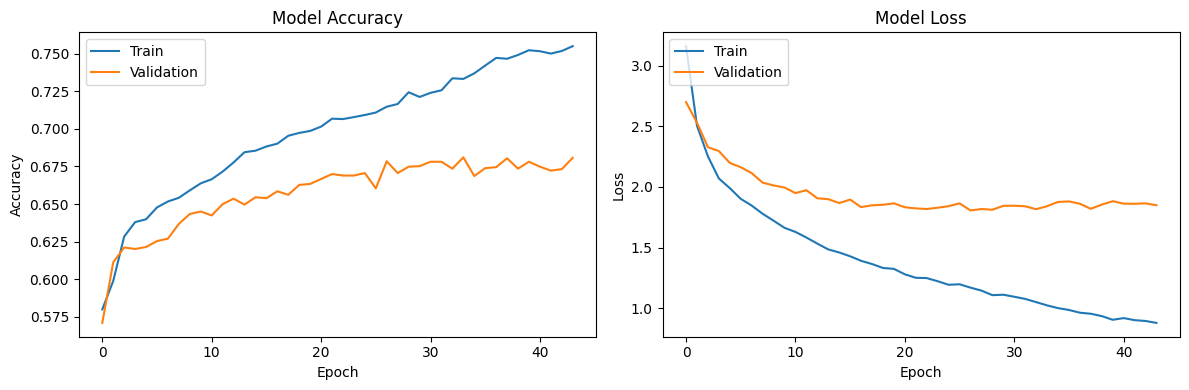

In [7]:

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.tight_layout()
plt.savefig("question_prediction_training_history.png")
plt.show()

# Simpan model dan tokenizer
model.save("question_prediction_model_final.h5")

# Simpan tokenizer
tokenizer_data = {
    "word_tokenizer": tokenizer.to_json(),
    "ner_tokenizer": ner_tokenizer.to_json(),
    "srl_tokenizer": srl_tokenizer.to_json(),
    "q_type_tokenizer": q_type_tokenizer.to_json(),
    "max_context_len": max_context_len,
    "max_question_len": max_question_len,
    "max_token_len": max_token_len,
}

with open("question_prediction_tokenizers.json", "w") as f:
    json.dump(tokenizer_data, f)



In [11]:

# Fungsi untuk memprediksi pertanyaan
def predict_question(context, tokens, ner, srl, q_type):
    context = preprocess_text(context)

    context_seq = tokenizer.texts_to_sequences([context])[0]
    token_seq = tokenizer.texts_to_sequences([" ".join(tokens)])[0]
    ner_seq = ner_tokenizer.texts_to_sequences([" ".join(ner)])[0]
    srl_seq = srl_tokenizer.texts_to_sequences([" ".join(srl)])[0]

    context_padded = pad_sequences(
        [context_seq], maxlen=max_context_len, padding="post"
    )
    token_padded = pad_sequences([token_seq], maxlen=max_token_len, padding="post")
    ner_padded = pad_sequences([ner_seq], maxlen=max_token_len, padding="post")
    srl_padded = pad_sequences([srl_seq], maxlen=max_token_len, padding="post")

    # Q-type one-hot encoding
    q_type_idx = q_type_tokenizer.word_index.get(q_type, 0)
    q_type_one_hot = tf.keras.utils.to_categorical(
        [q_type_idx], num_classes=q_type_vocab_size
    )

    # Predict
    pred = model.predict(
        [context_padded, token_padded, ner_padded, srl_padded, q_type_one_hot],
        verbose=0,
    )

    # Convert prediction to words
    pred_seq = np.argmax(pred[0], axis=1)

    # Convert indices to words
    reverse_word_map = {v: k for k, v in tokenizer.word_index.items()}
    pred_words = [reverse_word_map.get(i, "") for i in pred_seq if i != 0]

    return " ".join(pred_words)


def evaluate_model_performance(test_data):

    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

    # Lists to store scores
    bleu_scores = []
    rouge1_scores = []
    rouge2_scores = []
    rougel_scores = []

    # Iterate through test data
    for i in range(len(test_data)):
        # Get test sample
        sample_context = contexts[test_data[i]]
        sample_tokens = tokens_list[test_data[i]]
        sample_ner = ner_list[test_data[i]]
        sample_srl = srl_list[test_data[i]]
        sample_q_type = q_types[test_data[i]]
        actual_question = questions[test_data[i]]

        # Predict question
        pred_question = predict_question(
            sample_context, sample_tokens, sample_ner, sample_srl, sample_q_type
        )

        # Tokenize for BLEU score
        actual_tokens = actual_question.split()
        pred_tokens = pred_question.split()

        # Calculate BLEU score
        # Using unigram, bigram, trigram, and 4-gram
        # print("kaliamt aktual", actual_tokens)
        # print("kaliamt prediksi", pred_tokens)
        bleu_score = sentence_bleu([actual_tokens], pred_tokens)
        bleu_scores.append(bleu_score)

        try:
            rouge_scores = scorer.score(actual_question, pred_question)

            # Extract F1 scores
            rouge1_scores.append(rouge_scores["rouge1"].fmeasure)
            rouge2_scores.append(rouge_scores["rouge2"].fmeasure)
            rougel_scores.append(rouge_scores["rougeL"].fmeasure)
        except Exception as e:
            print(f"Error calculating ROUGE score: {e}")

    # Calculate average scores
    results = {
        "avg_bleu_score": np.mean(bleu_scores),
        "avg_rouge1": np.mean(rouge1_scores),
        "avg_rouge2": np.mean(rouge2_scores),
        "avg_rougel": np.mean(rougel_scores),
    }

    return results


loaded_model = load_model("question_prediction_model_final.h5")

with open("question_prediction_tokenizers.json", "r") as f:
    tokenizer_data = json.load(f)

# Ambil beberapa sampel dari data test
sample_idx = random.randint(0, len(test_indices) - 1)
sample_context = contexts[test_indices[sample_idx]]
sample_tokens = tokens_list[test_indices[sample_idx]]
sample_ner = ner_list[test_indices[sample_idx]]
sample_srl = srl_list[test_indices[sample_idx]]
sample_q_type = q_types[test_indices[sample_idx]]

performance_metrics = evaluate_model_performance(test_indices)

print("\nModel Performance Metrics:")
print(f"Average BLEU Score: {performance_metrics['avg_bleu_score'] * 100:.2f}%")
print(f"Average ROUGE-1 Score: {performance_metrics['avg_rouge1'] * 100:.2f}%")
print(f"Average ROUGE-2 Score: {performance_metrics['avg_rouge2'] * 100:.2f}%")
print(f"Average ROUGE-L Score: {performance_metrics['avg_rougel'] * 100:.2f}%")



Model Performance Metrics:
Average BLEU Score: 3.06%
Average ROUGE-1 Score: 38.89%
Average ROUGE-2 Score: 13.38%
Average ROUGE-L Score: 38.55%
